In [126]:
import pandas as pd
import matplotlib as mpl
import datetime as dt

%matplotlib inline

In [127]:
data = pd.read_csv('dataset.csv', index_col='Unnamed: 0')
data['order_time'] = pd.to_datetime(data['order_time'])

data.head()

,numbers_order,user_id,order_time,contragent,cost,status
0,2430,802,2020-03-30 14:02:00,Анонимный покупатель,11480.54,Доставлен
1,2431,76,2020-03-30 14:14:00,Ишбулатова Рина,3485.35,Доставлен
2,2432,60,2020-03-30 14:29:00,Екатерина,5354.98,Доставлен
3,2435,312,2020-03-30 14:41:00,Екатерина,3126.84,Доставлен
4,2437,857,2020-03-30 14:43:00,Анонимный покупатель,6252.00,Подтвержден


In [128]:
first = pd.to_datetime(data['order_time'].min())
last = pd.to_datetime(data['order_time'].max())
delta = (last - first).days
print(
    'first order: ' , data['order_time'].min(),
    'last oreder: ' , data['order_time'].max(),
    'delta days: ', delta,
    sep='\n'
)

first order: 
2020-03-30 14:02:00
last oreder: 
2020-07-01 23:42:56
delta days: 
93


###Потрачено каждым пользователем и количество заказов с каждого пользователя

In [129]:
users_purchases = data.groupby('user_id')['cost'].agg([sum, 'count'])
users_purchases.sort_values(by='sum', ascending=False)

,sum,count
user_id,,
105,201512.23,12
69,161489.74,6
892,131886.75,6
1182,124977.90,11
1022,120884.31,4
...,...,...
150,1111.38,1
58,0.01,1
421,0.01,1


###Образуем когорты по неделям и добавим их к основной таблице

In [130]:
def find_my_cohort(series):
    for time in series:
        time = time.date()
        now = first.date()
        week = pd.Timedelta('7 days')
        for i in range(delta):
            now += week
            if now > time:
                return pd.to_datetime(now - week)

f_orders = data.groupby('user_id')['order_time'].agg(first_order=min)

cohort = f_orders.groupby('user_id')['first_order'].agg(
    cohort=find_my_cohort
)

merged_data = data.merge(cohort, how='inner', left_on='user_id', right_index=True)
merged_data

,numbers_order,user_id,order_time,contragent,cost,status,cohort
0,2430,802,2020-03-30 14:02:00,Анонимный покупатель,11480.54,Доставлен,2020-03-30
260,2817,802,2020-04-06 09:32:00,[Интернет магазин],14200.34,Доставлен,2020-03-30
1,2431,76,2020-03-30 14:14:00,Ишбулатова Рина,3485.35,Доставлен,2020-03-30
2,2432,60,2020-03-30 14:29:00,Екатерина,5354.98,Доставлен,2020-03-30
3,2435,312,2020-03-30 14:41:00,Екатерина,3126.84,Доставлен,2020-03-30
...,...,...,...,...,...,...,...
2241,0000-000609,1106,2020-07-01 09:14:35,9268946162,5778.51,Доставлен,2020-06-29
2242,0000-000610,653,2020-07-01 10:58:13,9166415474,9635.01,Доставлен,2020-06-29
2244,0000-000612,423,2020-07-01 15:04:30,9153600886,4456.34,Доставлен,2020-06-29
2245,0000-000613,315,2020-07-01 15:10:06,9104659992,5183.59,Доставлен,2020-06-29


###Проверочка

In [131]:
merged_data.groupby(['user_id', 'cohort', 'order_time'])['cost'].agg(sum='sum').head(10)

sum
user_id cohort     order_time                  
0       2020-04-06 2020-04-12 14:45:00  7965.21
                   2020-04-14 18:44:00  1704.58
1       2020-05-04 2020-05-07 13:33:00  3624.19
2       2020-05-11 2020-05-15 20:22:00  8040.45
3       2020-04-27 2020-05-01 01:19:00  6643.00
                   2020-05-12 23:22:00  9479.17
4       2020-05-18 2020-05-21 16:06:00  5330.00
                   2020-05-30 21:05:00  9213.86
5       2020-05-25 2020-05-29 15:13:00  5706.94
6       2020-06-01 2020-06-07 13:48:00  4080.15

###Сумма и количество заказов с каждой когорты

In [132]:
group_by_cohort = merged_data.groupby('cohort')['cost'].agg(['sum', 'count']).head(20)
group_by_cohort

,sum,count
cohort,,
2020-03-30,2482592.81,328
2020-04-06,1461762.09,152
2020-04-13,1731400.41,195
2020-04-20,1385941.59,140
2020-04-27,1278451.19,154
2020-05-04,1529718.08,195
2020-05-11,1694811.04,217
2020-05-18,1919379.60,244
2020-05-25,1179710.01,168


Видно что количество заказов падает, как и выручка <br/>
Для наглядности сделаем график

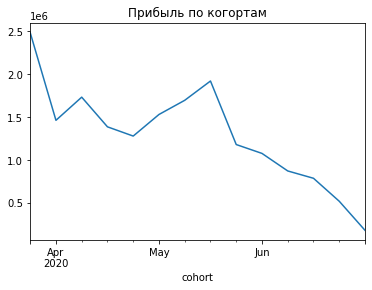

In [133]:
group_by_cohort['sum'].plot(title='Прибыль по когортам')

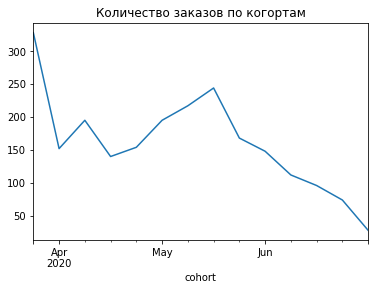

In [134]:
group_by_cohort['count'].plot(title='Количество заказов по когортам')
